# Generic programming

From [Wikipedia](https://en.wikipedia.org/wiki/Generic_programming):
> **Generic programming** is a style of computer programming in which algorithms are written in terms of types *to-be-specified-later* that are then *instantiated* when needed for specific types provided as parameters.

# Example: Vandermonde matrix (revisited)

[Vandermonde matrix:](https://en.wikipedia.org/wiki/Vandermonde_matrix)
\begin{align}V=\begin{bmatrix}1&\alpha _{1}&\alpha _{1}^{2}&\dots &\alpha _{1}^{n-1}\\1&\alpha _{2}&\alpha _{2}^{2}&\dots &\alpha _{2}^{n-1}\\1&\alpha _{3}&\alpha _{3}^{2}&\dots &\alpha _{3}^{n-1}\\\vdots &\vdots &\vdots &\ddots &\vdots \\1&\alpha _{m}&\alpha _{m}^{2}&\dots &\alpha _{m}^{n-1}\end{bmatrix}\end{align}

In [1]:
function vander_naive(x::Vector)
    m = length(x)
    V = Matrix{Float64}(undef, m, m)
    for j = 1:m
        V[j,1] = 1.0
    end
    for i= 2:m
        for j = 1:m
            V[j,i] = x[j] * V[j,i-1]
            end
        end
    return V
end

vander_naive (generic function with 1 method)

In [2]:
vander_naive(rand(3))

3×3 Array{Float64,2}:
 1.0  0.862984  0.744741
 1.0  0.464942  0.216171
 1.0  0.373003  0.139131

In [3]:
vander_naive(1:3)

MethodError: MethodError: no method matching vander_naive(::UnitRange{Int64})
Closest candidates are:
  vander_naive(!Matched::Array{T,1} where T) at In[1]:2

In [4]:
vander_naive([1,2,3])

3×3 Array{Float64,2}:
 1.0  1.0  1.0
 1.0  2.0  4.0
 1.0  3.0  9.0

Why is the result a matrix of floating point numbers....?

Even worse:

In [5]:
vander_naive(rand(ComplexF64, 3))

InexactError: InexactError: Float64(0.26499306996407834 + 0.45669431168389774im)

* Keep function argument types generic if possible
* Avoid explicit typing if possible

In [7]:
function vander_generic(x::AbstractVector{T}) where T
    m = length(x)
    V = Matrix{T}(undef, m, m)
    for j = 1:m
        V[j,1] = one(x[j])
    end
    for i= 2:m
        for j = 1:m
            V[j,i] = x[j] * V[j,i-1]
            end
        end
    return V
end

vander_generic (generic function with 1 method)

In [10]:
[3, "City", 4 + 5im]

3-element Array{Any,1}:
   3      
    "City"
 4 + 5im  

In [9]:
vander_generic([3, "City", 4 + 5im])

3×3 Array{Any,2}:
  1      3          9          
   ""     "City"     "CityCity"
 1+0im  4+5im     -9+40im      

### And all of this comes at no performance penality

In [11]:
using BenchmarkTools

In [12]:
x = rand(Float64, 100);
@btime vander_naive($x);
@btime vander_generic($x);

  6.680 μs (2 allocations: 78.20 KiB)
  6.940 μs (2 allocations: 78.20 KiB)


Actually, for this specific example **our generic code is faster** in a few cases inasmuch as type conversions are unnecessary.

In [13]:
x = rand(Int, 100);
@btime vander_naive($x);
@btime vander_generic($x);

  7.867 μs (2 allocations: 78.20 KiB)
  7.025 μs (2 allocations: 78.20 KiB)


In [14]:
x = rand(Bool, 100);
@btime vander_naive($x);
@btime vander_generic($x);

  7.933 μs (2 allocations: 78.20 KiB)
  6.200 μs (1 allocation: 9.94 KiB)


In [17]:
vander_naive(rand(Bool, 100))

100×100 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.

On the other hand, sometimes it is worth converting to a different type to dispatch to a faster method or to utilize magic like compiler optimizations.

In [15]:
x = rand(Float32, 100);
@btime vander_naive($x);
@btime vander_generic($x);

  8.167 μs (2 allocations: 78.20 KiB)
  24.000 μs (2 allocations: 39.14 KiB)


# Generic Programming + Multiple Dispatch + JIT

The possibility to write generic algorithms that compile to fast machine code in combination with multiple dispatch leads to an ([unreasonable](https://www.youtube.com/watch?v=kc9HwsxE1OY)) amount of code reuse. This sharing of code comes in two forms:
1. **Sharing generic algorithms**
 * Examples: StatsBase.jl, SortingAlgorithms.jl, GenericLinearAlgebra.jl,
 * **Methods are selected based on all argument types**
2. **Sharing types**
 * Examples: DataStructures.jl, OrderedCollections.jl, StaticArrays.jl, Colors.jl, Measurements.jl
 * **You can define methods on types after the type is defined!**

 <img src="revdeps.png" alt="drawing" width="800"/>

As of the time of this writing, **804 packages** depend on the data types provided in [DataStructures.jl](https://juliacollections.github.io/DataStructures.jl/latest/).

**851 packages** reuse type implementations in [OrderedCollections.jl](https://github.com/JuliaCollections/OrderedCollections.jl).

**That's about every third package!**

# Let's get a bit more fancy!

In [20]:
using Interact

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-11804782174269231667\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-4061775552807845906\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-11804782174269231667\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [21]:
@manipulate for n in 1:20
    [i*j for i in 1:n, j in 1:n]
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["n"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 20,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
10, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "C:\\Users\\carsten\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\carsten\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\carsten\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\carsten\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\carsten\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00000000133d59f0, Task (runnable) @0x00000000133d59f0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\"],\"changes\":WebIO.getval({\"name\":\"changes\"

In [22]:
function insert_block(A::AbstractMatrix, i, j, what=7)
    B = copy(A)
    B[i:i+2, j:j+2] .= what
    B
end

insert_block (generic function with 2 methods)

In [23]:
A = fill(0, 9, 9)
insert_block(A, 3, 5)  # this returns the new matrix

9×9 Array{Int64,2}:
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0
 0  0  0  0  7  7  7  0  0
 0  0  0  0  7  7  7  0  0
 0  0  0  0  7  7  7  0  0
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0

In [24]:
A = fill(0, 10, 10)
n = size(A, 1)

@manipulate for i in 1:n-2, j in 1:n-2
    insert_block(A, i, j)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 8,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
4, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "C:\\Users\\carsten\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\carsten\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\carsten\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\carsten\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\carsten\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000010bdf990, Task (runnable) @0x0000000010bdf990), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"14480119894339629000\",\"id\":\"ob_10\",\"type\":\"observable\"}),\"inde

### Let's add some color!

Our function `insert_block` is generic. Since the first argument `A isa AbstractArray`, we can index into it and set new values. Pretty much every value type is fine!

In [25]:
using Colors

In [26]:
@manipulate for n in 1:80
    distinguishable_colors(n)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["n"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 80,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
40, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "C:\\Users\\carsten\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\carsten\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\carsten\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\carsten\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\carsten\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000001466f990, Task (runnable) @0x000000001466f990), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\

In [27]:
colors = distinguishable_colors(10)

In [28]:
colors[1]

In [29]:
A = fill(colors[1], 10, 10)
n = size(A, 1)

@manipulate for i in 1:n-2, j in 1:n-2
    insert_block(A, i, j, colors[4])
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 8,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
4, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "C:\\Users\\carsten\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\carsten\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\carsten\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\carsten\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\carsten\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000010832e10, Task (runnable) @0x0000000010832e10), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"4724126433195183244\",\"id\":\"ob_28\",\"type\":\"observable\"}),\"index

## Emergent features: Example DifferentiaEquations.jl

$$\frac{du}{dt} = f(u,p,t)$$

In [30]:
using OrdinaryDiffEq

#Half-life of Carbon-14 is 5730 years.
c = 5.730

#Setup
u0 = 1.0
tspan = (0.0, 1.0)

#Define the problem
radioactivedecay(u,p,t) = -c*u

#Pass to solver
prob = ODEProblem(radioactivedecay,u0,tspan)

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 1.0)
u0: 1.0

In [31]:
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

In [33]:
sol

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 48-element Array{Float64,1}:
 0.0                 
 0.005714051500552912
 0.012379826760550444
 0.020651037805054586
 0.03004681435830501 
 0.04070854539069554 
 0.05238349020339421 
 0.06503229073547978 
 0.07850151814028625 
 0.09271387667665579 
 0.10756985966150515 
 0.12300225198861972 
 0.138947020090579   
 ⋮                   
 0.6453950724149814  
 0.6731066242118364  
 0.7016050289669591  
 0.7309377970881783  
 0.7611563618391454  
 0.7923165368904431  
 0.8244790385346232  
 0.8577100893666962  
 0.8920821072291529  
 0.9276745272678372  
 0.9645747329176846  
 1.0                 
u: 48-element Array{Float64,1}:
 1.0                  
 0.9677886860242481   
 0.931521128152587    
 0.8884024345211743   
 0.8418375252286853   
 0.7919476680197977   
 0.7407016259183957   
 0.6889166236940075   
 0.6377469535070397   
 0.5878693713657285   
 0.5398978652256643   
 0.4942059707831529   
 0.4510548063

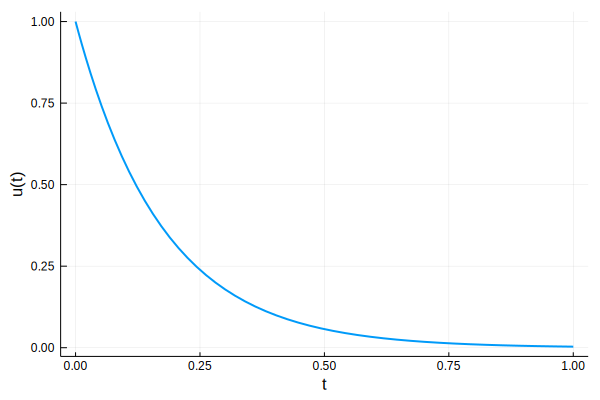

In [32]:
using Plots

plot(sol.t, sol.u, ylabel="u(t)", xlabel="t", lw=2, legend=false)

In [34]:
big(3.2)

3.20000000000000017763568394002504646778106689453125

### Arbitrary precision

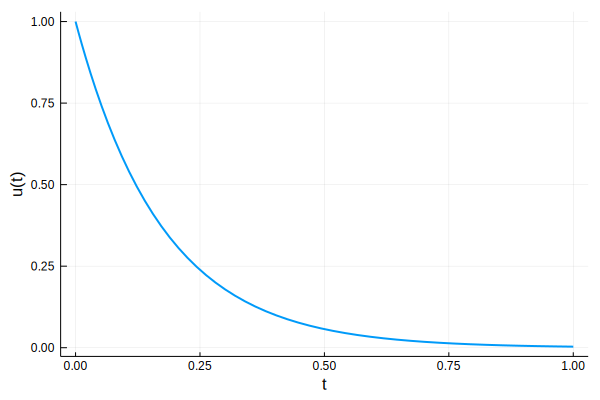

In [35]:
using OrdinaryDiffEq, Measurements, Plots

#Half-life of Carbon-14 is 5730 years.
c = big(5.730) # now a BigFloat

#Setup
u0 = big(1.0) # now a BigFloat
tspan = (0.0, 1.0)

#Define the problem
radioactivedecay(u,p,t) = -c*u

#Pass to solver
prob = ODEProblem(radioactivedecay,u0,tspan)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

plot(sol.t, sol.u, ylabel="u(t)", xlabel="t", lw=2, legend=false)

In [36]:
sol.u

48-element Array{BigFloat,1}:
 1.0                                                                                
 0.9677886860242480802598783250713916010081415505397800881445406271537611300017618  
 0.9315211281525870696951220469884643089015968992100693760200740553948355529147443  
 0.8884024345211743161021160493163086874961411762569637929039406549449358585920417  
 0.8418375252286853526018156034028654546424997684271563776179902463787617679492211  
 0.7919476680197978130129370628972353995826991637831352877688831499482679169139974  
 0.7407016259183958391757039618594165227639572775337525341594247992333817572100918  
 0.6889166236940076080002239132042014361405924597885439675027524004548444995732002  
 0.6377469535070398349649293862161431951718088662130859799205713009042556096647567  
 0.5878693713657286439755737446549580093909012667283176744130450838954131268967931  
 0.5398978652256644388443113633025199796421787288250581423811316455632597496131444  
 0.49420597078315307183358331460464

### With uncertainties: Measurements.jl

`Measurement` type from [Measurements.jl]() and differential equation solver from [OrdinaryDiffEq.jl](https://github.com/JuliaDiffEq/OrdinaryDiffEq.jl) (i.e. [DifferentialEquations.jl](https://github.com/JuliaDiffEq/DifferentialEquations.jl))

In [38]:
using Measurements

In [39]:
x = 4 ± 0.1

4.0 ± 0.1

In [40]:
1/x

0.25 ± 0.0062

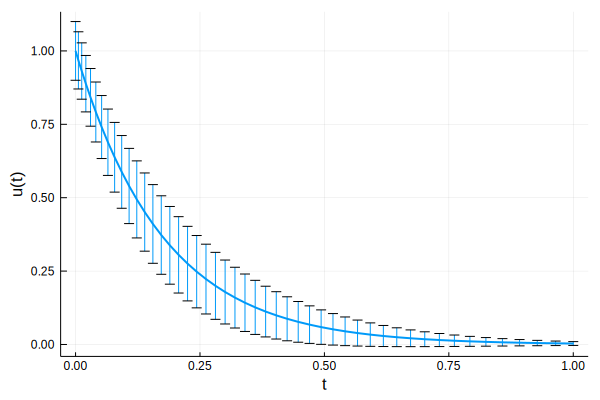

In [41]:
using OrdinaryDiffEq, Measurements, Plots

#Half-life of Carbon-14 is 5730 years.
c = 5.730 ± 2

#Setup
u0 = 1.0 ± 0.1
tspan = (0.0, 1.0)

#Define the problem
radioactivedecay(u,p,t) = -c*u

#Pass to solver
prob = ODEProblem(radioactivedecay,u0,tspan)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

plot(sol.t, sol.u, ylabel="u(t)", xlabel="t", lw=2, legend=false)

Note that, in some sense, **Julia implemented that feature by itself**.

The authors of Measurements.jl and DifferentialEquations.jl never had any collabration on this.

It **just works**.

# Core messages of this Notebook

* It is simple to write **type-generic code** in Julia and you should do it.
* Generally, **generic code is just as fast as specific code**.
* Generic Programming + Multiple Dispatch + JIT = **lots of code sharing and emergent features**